In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [228]:
df = pd.read_csv('data/consumption.csv', sep=';')
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'], dayfirst= True)
df.drop(columns=['Hour', 'Res consumption', 'Date'], inplace = True)
df.set_index('Datetime', inplace= True)
df.head()


,Consumption
Datetime,
2018-04-01 00:00:00,763
2018-04-01 01:00:00,741
2018-04-01 02:00:00,714
2018-04-01 03:00:00,680
2018-04-01 04:00:00,684


In [229]:
df = df.query('`Consumption` > 1').copy()
df = df.query('`Consumption` < 50000').copy()

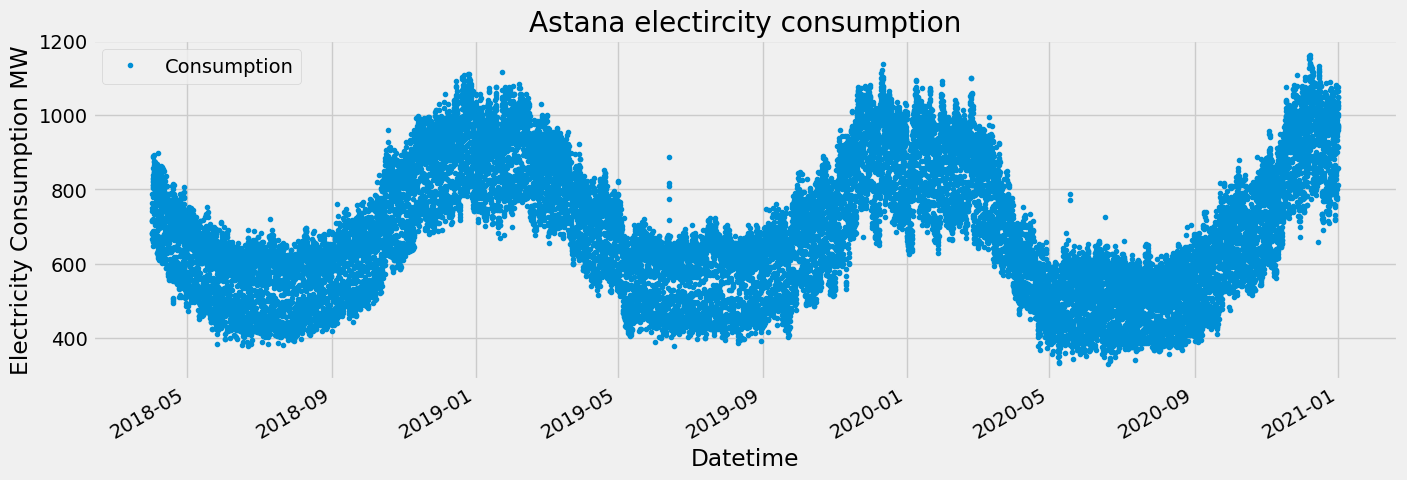

In [230]:
df.plot(style='.', figsize=(15, 5), color= color_pal[0], title="Astana electircity consumption", ylabel = "Electricity Consumption MW")
plt.savefig('images_akm/Akm_eletrisity_consumption.png', dpi=300)

# Train / Test split

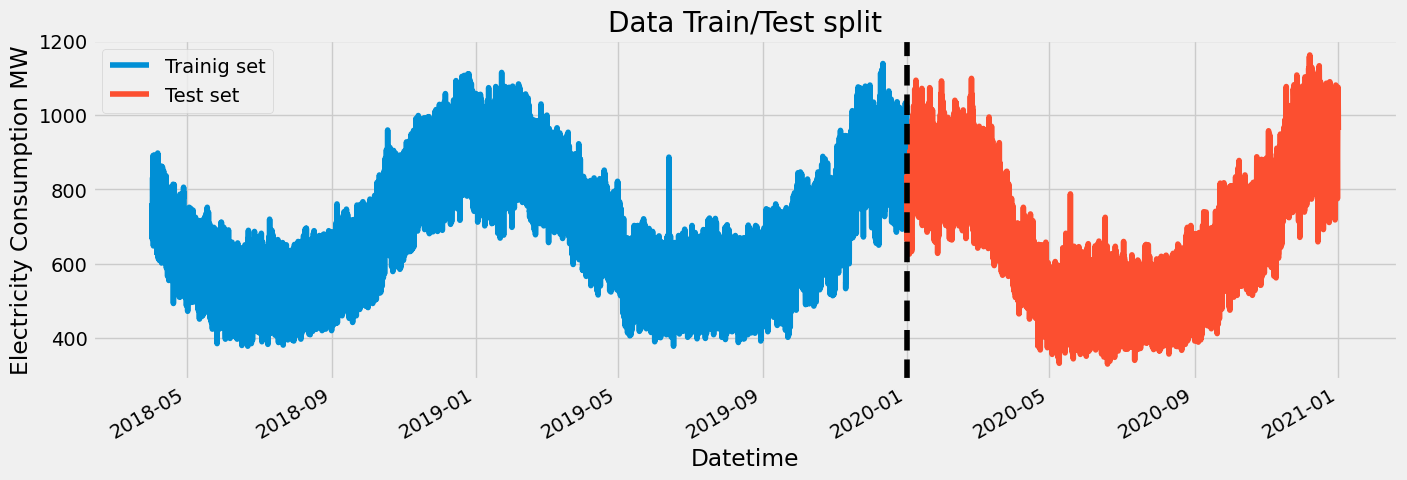

In [231]:
train = df.loc[df.index < '01.01.2020']
test = df.loc[df.index >= '01.01.2020']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax = ax, label="Traning set", title="Data Train/Test split", ylabel = "Electricity Consumption MW")
test.plot(ax = ax, label = "Test set")
ax.axvline('01-01-2020', color = 'black', ls='--')
ax.legend(['Trainig set', 'Test set'])
plt.savefig('images_akm/Akm_Train_Test.png', dpi=300)
plt.show()

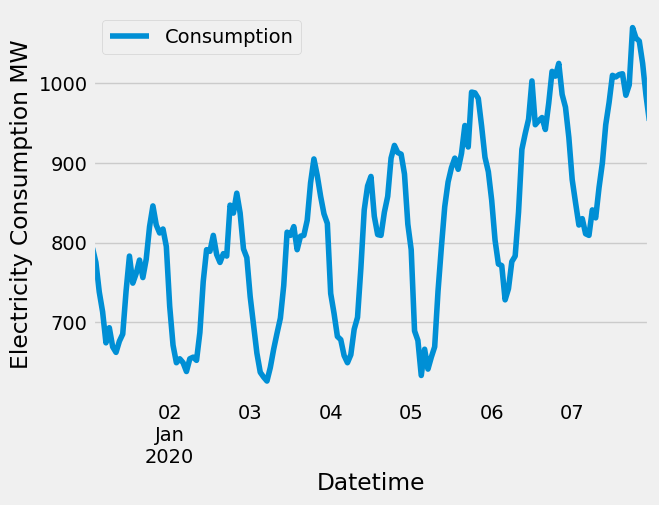

In [232]:
df_week = df.loc[(df.index > '01-01-2020') & (df.index < '01-08-2020')].plot()
plt.savefig('images_akm/Akm_consumption_week.png', dpi=300)
plt.ylabel("Electricity Consumption MW")
plt.show()

In [233]:
def create_featuAkm(df):
    """
    Create time series featuAkm based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    # df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    # df['dayofyear'] = df.index.dayofyear
    # df['dayofmonth'] = df.index.day
    # df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_featuAkm(df)

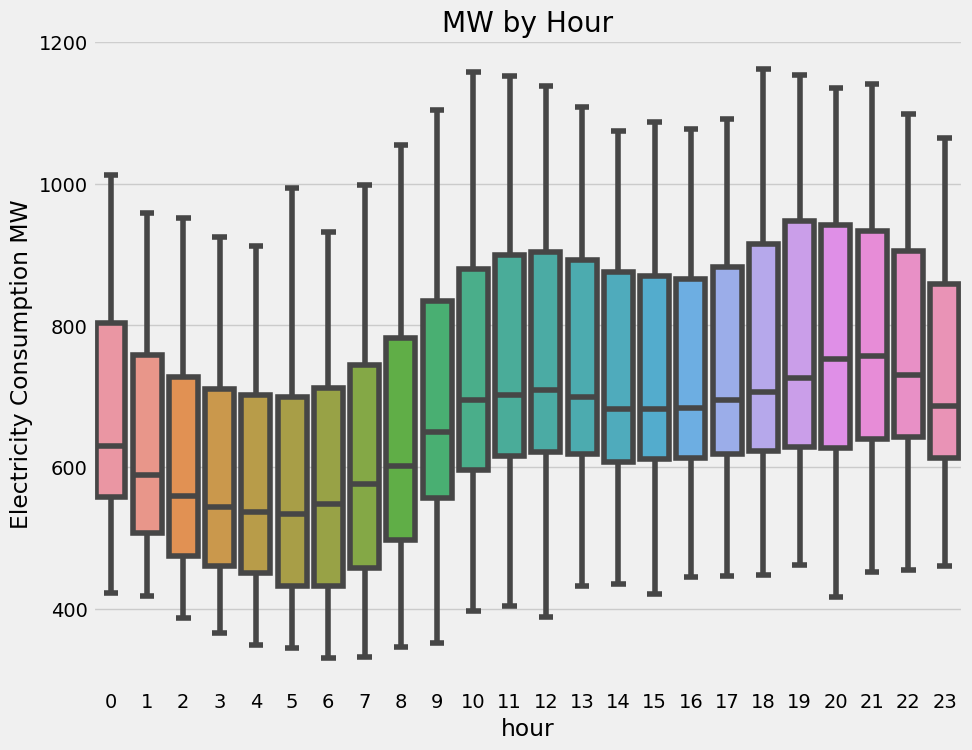

In [234]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Consumption')
ax.set_title('MW by Hour')

plt.ylabel("Electricity Consumption MW")
plt.savefig('images_akm/MW_by_hour.png', dpi=300)
plt.show()

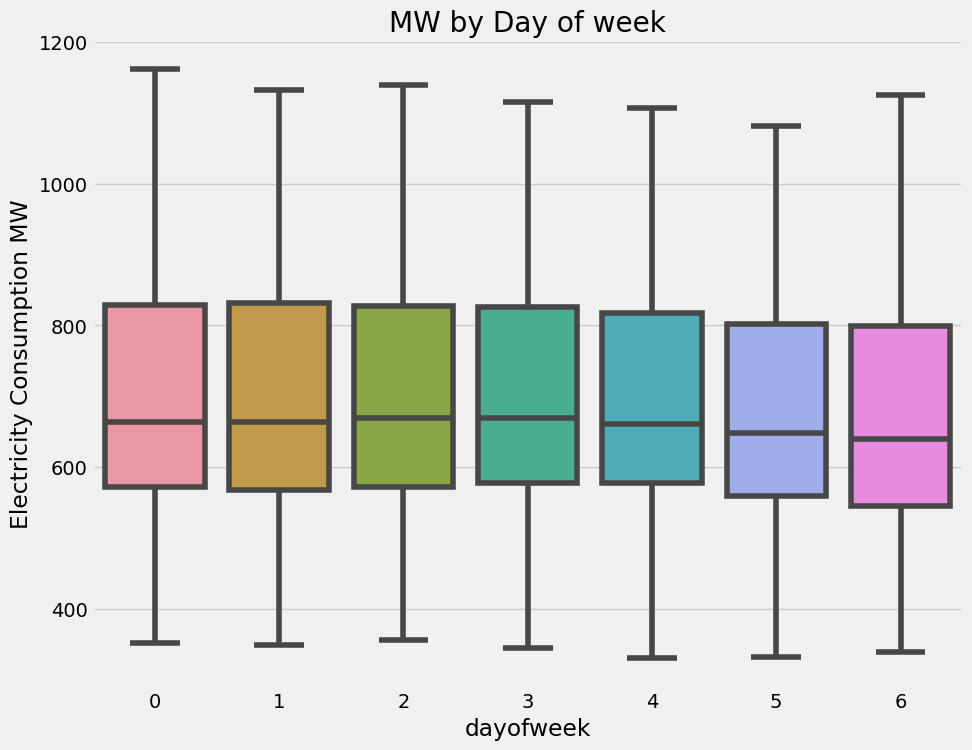

In [235]:
days = ["Mon", "Thues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Consumption')
ax.set_title('MW by Day of week')
plt.xticks
plt.ylabel("Electricity Consumption MW")
plt.savefig('images_akm/MW_by_days.png', dpi=300)
plt.show()

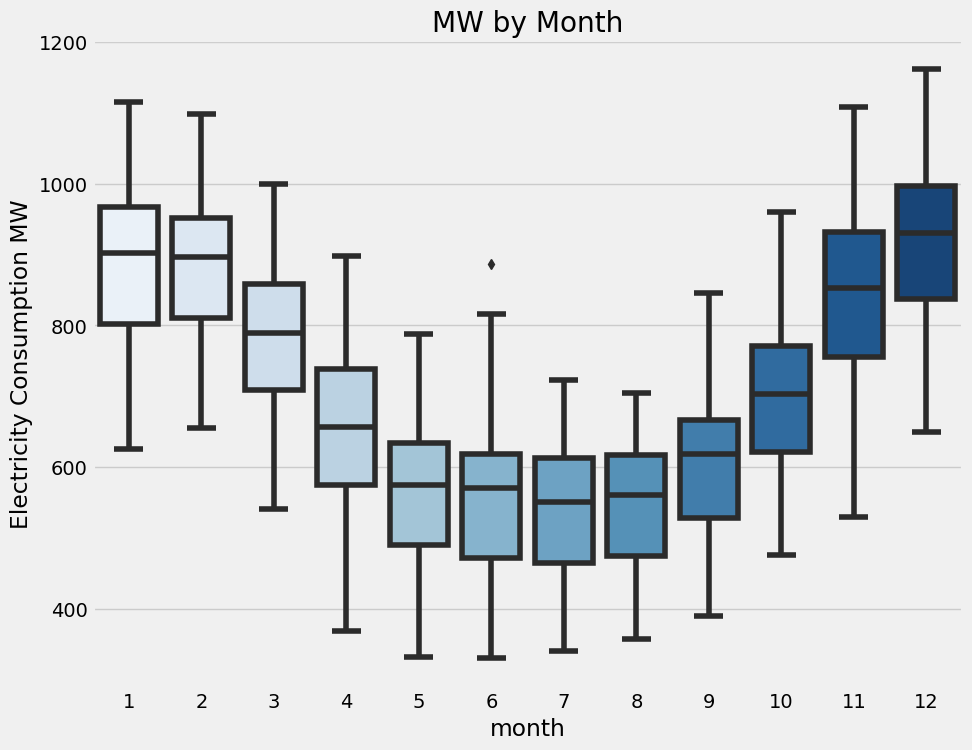

In [236]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Consumption', palette='Blues')
ax.set_title('MW by Month')
plt.ylabel("Electricity Consumption MW")
plt.savefig('images_akm/MW_by_month.png', dpi=300)
plt.show()

## Lag FeatuAkm

In [237]:
def add_lags(df):
    target_map = df['Consumption'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    return df

In [238]:
df = add_lags(df)
df.tail()

,Consumption,hour,dayofweek,month,year,lag1,lag2,lag3
Datetime,,,,,,,,
2020-12-31 19:00:00,1065,19,3,12,2020,1050.0,537.0,837.0
2020-12-31 20:00:00,1049,20,3,12,2020,1025.0,526.0,862.0
2020-12-31 21:00:00,1024,21,3,12,2020,998.0,564.0,837.0
2020-12-31 22:00:00,997,22,3,12,2020,966.0,583.0,792.0
2020-12-31 23:00:00,960,23,3,12,2020,914.0,555.0,781.0


# Create Model


In [239]:
train = create_featuAkm(train)
test = create_featuAkm(test)

train.head()
FEATURES = [ 'hour', 'month', 'dayofweek', 'year']
TARGET = 'Consumption'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [240]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[18:27:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:708.65004	validation_1-rmse:695.80071
[100]	validation_0-rmse:266.09839	validation_1-rmse:247.17078
[200]	validation_0-rmse:110.01809	validation_1-rmse:103.40055
[300]	validation_0-rmse:61.55778	validation_1-rmse:78.50740
[374]	validation_0-rmse:51.09728	validation_1-rmse:78.85912


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importance

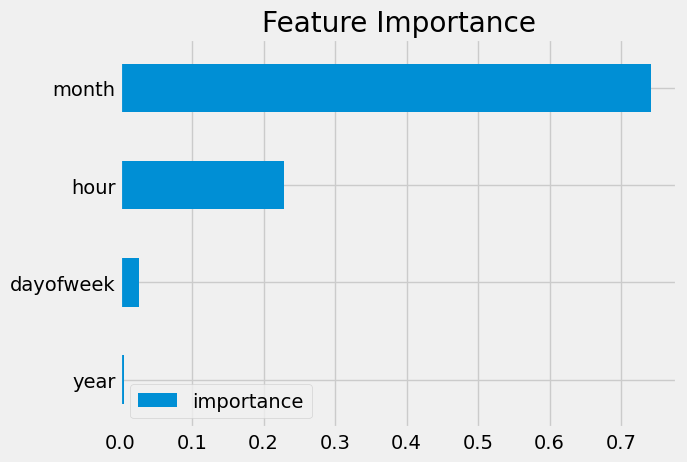

In [241]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test


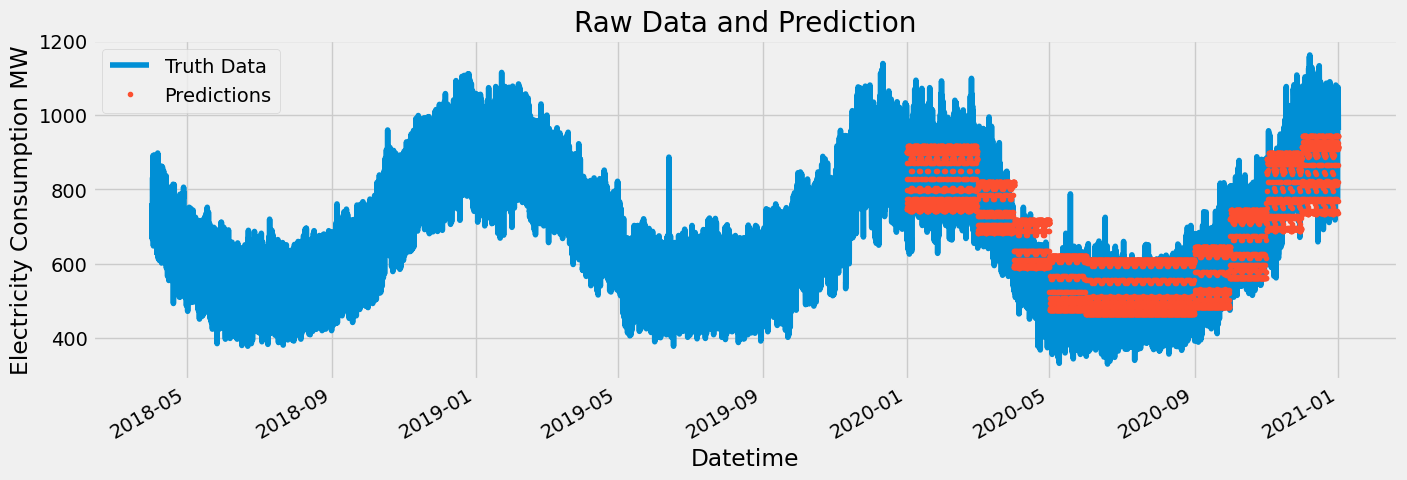

In [242]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Consumption']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
ax.set_ylabel("Electricity Consumption MW")
plt.savefig('images_akm/Akm_Prediction.png', dpi=300)
plt.show()

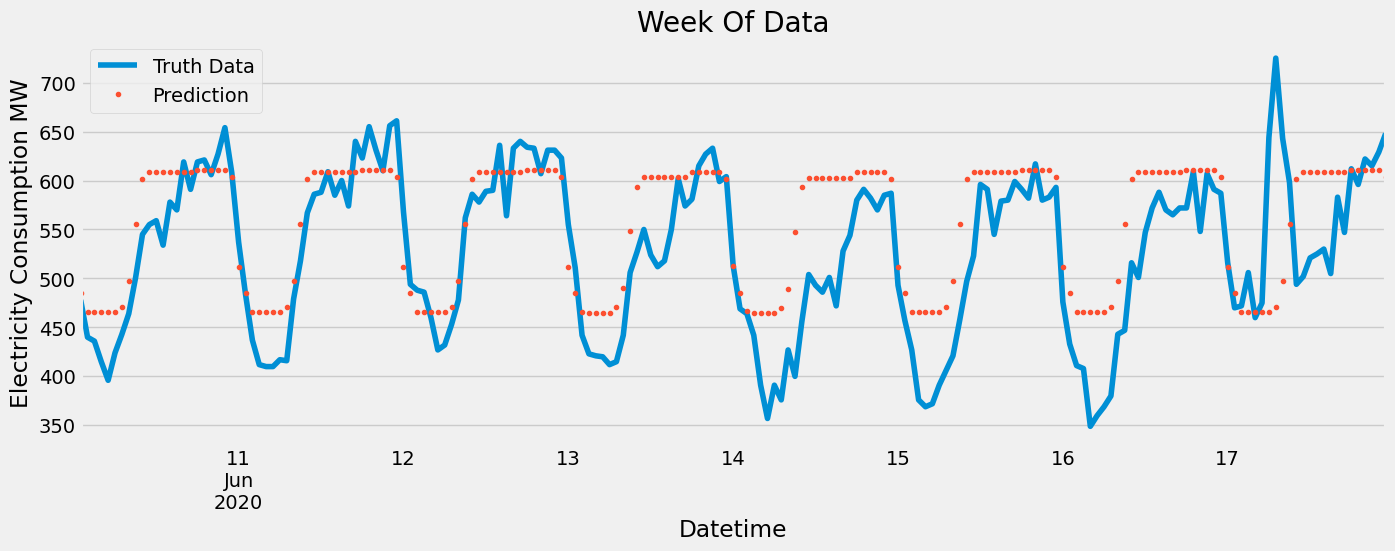

In [243]:
ax = df.loc[(df.index > '06-10-2020') & (df.index < '06-18-2020')]['Consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '06-10-2020') & (df.index < '06-18-2020')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.ylabel("Electricity Consumption MW")
plt.savefig('images_akm/Akm_week_prediction.png', dpi=300)
plt.show()

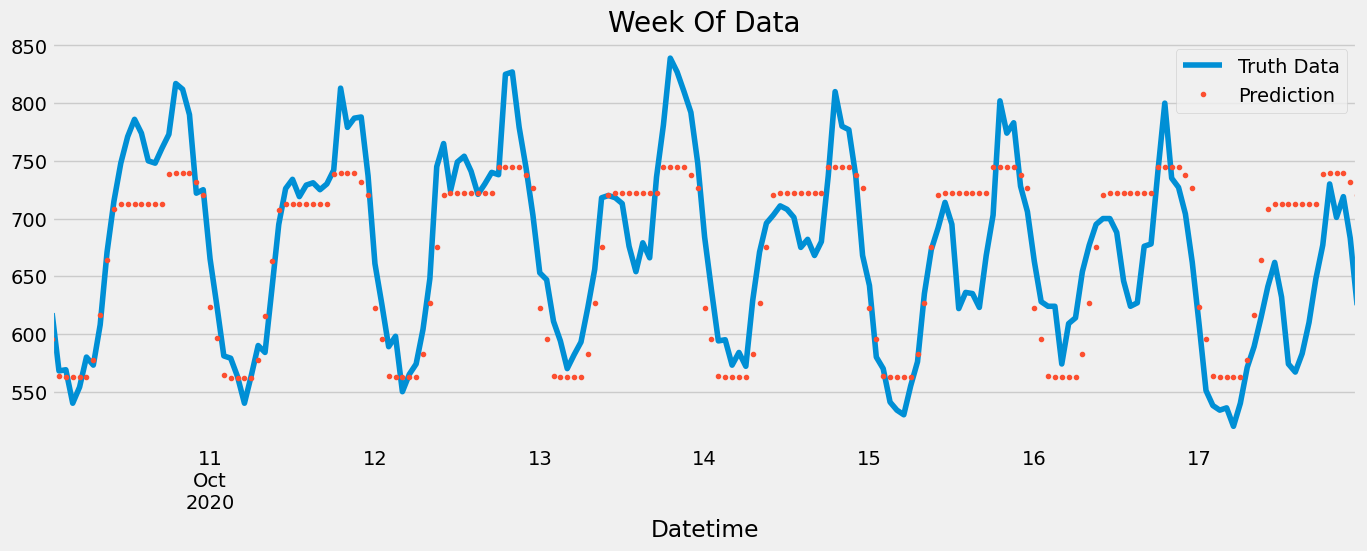

In [244]:
ax = df.loc[(df.index > '10-10-2020') & (df.index < '10-18-2020')]['Consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '10-10-2020') & (df.index < '10-18-2020')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.savefig('images_akm/Akm_week_prediction.png', dpi=300)
plt.show()

## Score MSE


In [245]:
score = np.sqrt(mean_squared_error(test['Consumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 78.16


## Calculate Error

In [246]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2020-04-29    196.867800
2020-12-07    186.385991
2020-04-30    185.951134
2020-04-28    167.659467
2020-04-26    165.742149
2020-04-22    162.659467
2020-04-23    161.659467
2020-04-27    159.576134
2020-04-21    158.117800
2020-12-15    150.177658
Name: error, dtype: float64

In [247]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2020-10-02    21.697268
2020-10-21    22.019162
2020-02-26    22.033981
2020-09-05    22.055405
2020-02-16    22.202710
2020-09-14    22.906195
2020-06-12    22.929766
2020-10-11    23.091075
2020-11-12    23.360891
2020-09-17    23.927171
Name: error, dtype: float64

## Train Using Cross Validation

In [248]:

df = create_featuAkm(df)


FEATURES = ['hour', 'month', 'dayofweek', 'year',
            'lag1','lag2','lag3']
TARGET = 'Consumption'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

df.to_csv('data/new_data.csv', index=False)
print(df)


[18:27:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:704.12784
[100]	validation_0-rmse:266.05060
[200]	validation_0-rmse:111.79565
[300]	validation_0-rmse:64.88724
[400]	validation_0-rmse:53.46141
[499]	validation_0-rmse:50.51459
                     Consumption  hour  dayofweek  month  year    lag1   lag2  \
Datetime                                                                        
2018-04-01 00:00:00          763     0          6      4  2018     NaN    NaN   
2018-04-01 01:00:00          741     1          6      4  2018     NaN    NaN   
2018-04-01 02:00:00          714     2          6      4  2018     NaN    NaN   
2018-04-01 03:00:00          680     3          6      4  2018     NaN    NaN   
2018-04-01 04:00:00          684     4          6      4  2018     NaN    NaN   
...                 

## Create future dataframe

In [249]:

future = pd.date_range('2021-01-01','2021-12-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_featuAkm(df_and_future)
df_and_future = add_lags(df_and_future)

In [250]:
future_w_featuAkm = df_and_future.query('isFuture').copy()

## Predict the future¶

In [251]:
future_w_featuAkm['pred'] = reg.predict(future_w_featuAkm[FEATURES])
future_w_featuAkm

,Consumption,hour,dayofweek,month,year,lag1,lag2,lag3,prediction,isFuture,pred
2021-01-01 00:00:00,NaN,0,4,1,2021,862.0,496.0,732.0,NaN,True,765.782471
2021-01-01 01:00:00,NaN,1,4,1,2021,808.0,471.0,697.0,NaN,True,731.500732
2021-01-01 02:00:00,NaN,2,4,1,2021,784.0,401.0,661.0,NaN,True,696.771362
2021-01-01 03:00:00,NaN,3,4,1,2021,773.0,410.0,637.0,NaN,True,672.410156
2021-01-01 04:00:00,NaN,4,4,1,2021,788.0,388.0,631.0,NaN,True,680.269287
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 20:00:00,NaN,20,1,11,2021,NaN,NaN,1025.0,NaN,True,878.953735
2021-11-30 21:00:00,NaN,21,1,11,2021,NaN,NaN,998.0,NaN,True,878.953735
2021-11-30 22:00:00,NaN,22,1,11,2021,NaN,NaN,966.0,NaN,True,871.609009
2021-11-30 23:00:00,NaN,23,1,11,2021,NaN,NaN,914.0,NaN,True,834.491760


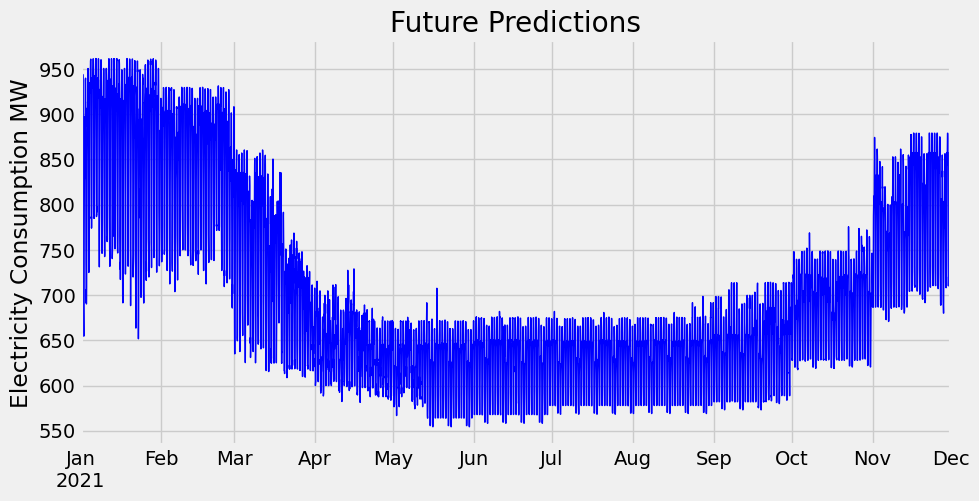

In [252]:
future_w_featuAkm['pred'].plot(figsize=(10, 5),
                               color='blue',
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.ylabel("Electricity Consumption MW")
plt.savefig('images_akm/future_prediction.png', dpi=300)
plt.show()

In [253]:
reg.save_model("model.json")

In [254]:
import pickle
with open("electrcity_pred_model.pickle", "wb") as f:
    pickle.dump(reg, f)